# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [1]:
import pandas as pd

df = pd.read_csv('data/human_body_temperature.csv')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

print(df.head())
print(df.describe())

   temperature gender  heart_rate
0         99.3      F        68.0
1         98.4      F        81.0
2         97.8      M        73.0
3         99.2      F        66.0
4         98.0      F        73.0
       temperature  heart_rate
count   130.000000  130.000000
mean     98.249231   73.761538
std       0.733183    7.062077
min      96.300000   57.000000
25%      97.800000   69.000000
50%      98.300000   74.000000
75%      98.700000   79.000000
max     100.800000   89.000000


** 1) Is the distribution of body temperatures normal? **

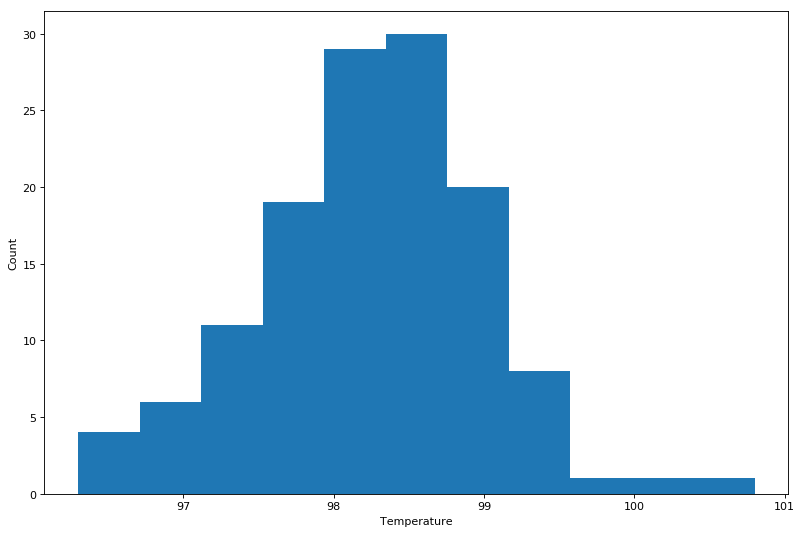

In [3]:
# Plot the histogram of temperature data
plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
_ = plt.hist('temperature', data = df, bins = int(np.sqrt(130)))
_ = plt.xlabel('Temperature')
_ = plt.ylabel('Count')

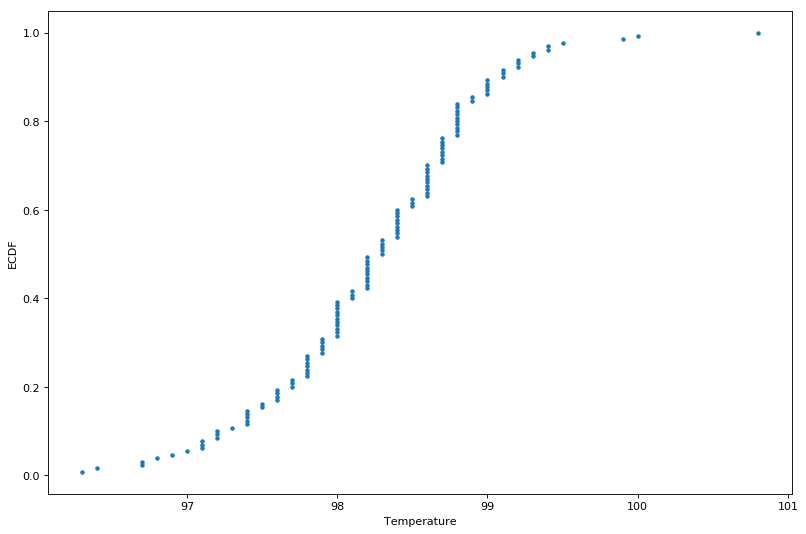

In [4]:
# Plot ECDF of temperature data
plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
x = np.sort(df['temperature'])
y = np.arange(1, len(x) + 1) / len(x)
_ = plt.plot(x, y, marker='.', linestyle='none')
_ = plt.xlabel('Temperature')
_ = plt.ylabel('ECDF')

Although the histogram looks like a normal distribution, I want to be sure by comparing it with the Shapiro-Wilk Test. With the Shapiro-Wilk test, I'm testing the null hypothesis that the data set is of normality with a alpha, or p-value, of 0.05. If my p-value is greater than our alpha, I fail to reject the null hypothesis.

In [5]:
# Get the p-value of temperature data using Shapio-Wilk test
stat, p = shapiro(df['temperature'])
print(p)

0.2331680953502655


With a p-value of 0.23 > 0.05, I fail to reject the null hypothesis and therefore can't reject that the data set is not normal.

** 2) Is the sample size large? Are the observations independent? **

To satisfy conditions of the Central Limit Theorem, the data set must be greater than 30 observations. If we look at df.describe(), we see that there are 130 total observations. This means that this data set is large enough to to make statistical inferences on the true population. Each observation can be considered independent as well since not one observation affects another.

** 3) Is the true population mean really 98.6 degrees F? **

+ First, try a bootstrap hypothesis test.
+ Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
+ In this situation, is it appropriate to use the  tt  or  zz  statistic?
+ Now try using the other test. How is the result be different? Why?

In [6]:
# Create a function that will sample data, take the mean, and store it in an array
def bs_mean(data, size=1):
    ### This function takes 'size' number of points from 'data' a 'run' number ###
    ### of times and returns an array of means for each run ###
    
    # Set the seed number
    np.random.seed(25)
    
    samples = np.empty(size)
    for i in range(size):
        sample = np.random.choice(data, len(data))
        samples[i] = np.mean(sample)
    return samples

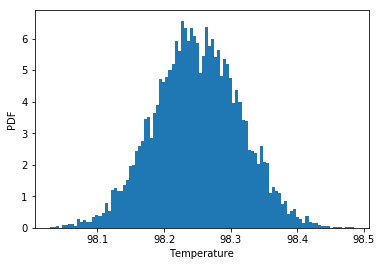

In [7]:
# Develop bootstrap sample of mean temperature data
sample_means = bs_mean(df['temperature'], size = 10000)
_ = plt.hist(sample_means, bins = 100, normed=True)
_ = plt.xlabel('Temperature')
_ = plt.ylabel('PDF')

In [8]:
confidence_inter = np.percentile(sample_means, [2.5, 97.5])
print(confidence_inter)

[98.12384615 98.37386538]


This distribution seems to be normalized around 98.2 degrees and 98.3 degrees but we have 95% confidence that the true mean is between 98.1 degrees and 98.4 degrees. To test this, I'll have to provide a confidence interval and devise a hypothesis test to see if it's possible for the true population mean to be 98.6 degrees.

I propose that the null hypothesis is that the mean of the data is 98.6 degrees. In order to make a hypothesis test, I need to shift the data so that the mean is 98.6 degrees and come up with a test statistic and p-value.

In [12]:
true_pop_mean = 98.6

# Shift the data so the mean is 98.6
temp_shifted = df['temperature'] - np.mean(df['temperature']) + true_pop_mean

# Calculate the observed difference of the mean and true population mean, 98.6
obs_mean_diff = np.mean(df['temperature']) - true_pop_mean

# Perform a bootstrap sample and replicate of the difference from the true population mean
bs_temp_shifted = bs_mean(temp_shifted, size=10000)
bs_temp_shifted = bs_temp_shifted - true_pop_mean

# Calculate the p-value
p_value = np.sum(bs_temp_shifted <= obs_mean_diff)/len(bs_temp_shifted)
print(p)

0.2331680953502655


With this p-value, it's reasonable that the observation data gave a mean this drastic from 98.6 degrees. In other words, the true population mean temperature could be 98.6 degrees.

** 4) Draw a small sample of size 10 from the data and repeat both requentist tests. **

** 5) At what temperature should we consider someone's temperature to be "abnormal"? **

** 6) Is there a significant difference between males and females in normal temperature? **